# 02 · Fine-tuning Eficiente con QLoRA

❤️ Creado por [@Edison_Bejarano](https://github.com/EjbejaranosAI/llm-hub/blob/main/mastery/notebooks/).

**Objetivo:** entrenar con QLoRA sobre un dataset pequeño (ej. Alpaca subset) y evaluar pérdidas.

Este notebook muestra, de forma práctica, **cómo reducir memoria y coste de inferencia** en LLMs con cuantización, y cómo hacer **fine-tuning eficiente** con **QLoRA**.

**Índice:**

1. **Parte A — Cuantización con bitsandbytes (8-bit / 4-bit)**  
Cargamos el mismo modelo en **8-bit (LLM.int8)** y **4-bit (NF4)** usando la API moderna de Transformers (pasando un `BitsAndBytesConfig` en `quantization_config`). Medimos **pico de VRAM**, **tiempo por generación** y **tokens/seg** para comparar. (Transformers documenta que 8-bit suele **reducir la memoria a la mitad**; 4-bit ahorra aún más).

2. **Parte B — Fine-tuning con QLoRA (4-bit + LoRA)**  
Entrenamos **solo adapters** (LoRA) encima de un **modelo base cuantizado a 4-bit (NF4)**. QLoRA añade **double quantization** y **paged optimizers** para que el entrenamiento **quepa en una sola GPU** manteniendo calidad cercana a 16-bit en benchmarks (llegando hasta 65B en 48GB en el paper). Implementamos el flujo con **Transformers + PEFT + TRL (SFTTrainer)**.


# Parte A

## 1. Setup

In [1]:
!pip -q install -U transformers datasets peft bitsandbytes accelerate trl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [2]:
# =========================
# UTILS
# =========================

import time, torch, statistics as stats, pandas as pd, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from IPython.display import display

# ---------- Métrica de VRAM pico ----------
def gpu_peak_gb():
    """Devuelve el pico de VRAM consumida en GB."""
    if not torch.cuda.is_available():
        return 0.0
    torch.cuda.synchronize()
    return torch.cuda.max_memory_allocated() / (1024**3)

# ---------- Función de benchmarking ----------
def gen_and_bench_multi(model, tok, prompt, max_new=64, runs=10):
    """
    Genera texto 'runs' veces y devuelve métricas:
      - sec_list / tps_list: listas por repetición
      - sec_mean / tps_mean / tps_std
      - peak_gb: VRAM pico
    """
    device = next(model.parameters()).device
    inputs = tok(prompt, return_tensors="pt").to(device)

    # Warmup
    with torch.inference_mode():
        _ = model.generate(**inputs, max_new_tokens=8)

    # Reset pico VRAM
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

    sec_list, tps_list = [], []
    with torch.inference_mode():
        for _ in range(runs):
            t0 = time.perf_counter()
            out = model.generate(**inputs, max_new_tokens=max_new)
            t1 = time.perf_counter()
            gen_tokens = out.shape[-1] - inputs["input_ids"].shape[-1]
            sec = t1 - t0
            tps = gen_tokens / sec if sec > 0 else float("nan")
            sec_list.append(sec)
            tps_list.append(tps)

    peak = gpu_peak_gb()
    return {
        "sec_list": sec_list,
        "tps_list": tps_list,
        "sec_mean": sum(sec_list)/len(sec_list),
        "tps_mean": sum(tps_list)/len(tps_list),
        "tps_std": stats.pstdev(tps_list) if len(tps_list)>1 else 0.0,
        "peak_gb": peak
    }

# ---------- Función para generar dataframe bonito ----------
def build_benchmark_df(rows):
    df = pd.DataFrame(rows)
    display(df)
    return df

# ---------- Función para resumen relativo vs FP16 ----------
def summary_vs_fp16(df, baseline="FP16 (baseline)"):
    if baseline not in df["config"].values:
        return "No hay baseline FP16; compara 8-bit vs 4-bit directamente."
    base = df.set_index("config").loc[baseline]
    lines = []
    for _, row in df.iterrows():
        if row["config"] == baseline:
            continue
        vram_saving = (base["peak_VRAM_GB"] - row["peak_VRAM_GB"]) / base["peak_VRAM_GB"] * 100.0
        tps_gain = (row["tok/s"] - base["tok/s"]) / base["tok/s"] * 100.0
        lines.append(f"- {row['config']}: ahorro VRAM ≈ {vram_saving:.1f}% | mejora tokens/s ≈ {tps_gain:.1f}%")
    return "Resumen vs FP16:\n" + "\n".join(lines)

# ---------- Función para gráficos ----------
def plot_benchmark(df, per_run):
    """
    Genera gráficos de barras con error bars y boxplots para tokens/s
    """
    # --- Barras con error ---
    plt.figure(figsize=(8,4.5))
    ax = df.plot(kind="bar", x="config", y="tok/s", yerr=df.get("tok/s_std", None), capsize=4, legend=False)
    plt.title("Rendimiento (tokens/s) — media ± std")
    plt.ylabel("tokens/s")
    plt.xticks(rotation=15, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height:.1f}", (p.get_x() + p.get_width()/2, height),
                    xytext=(0, 5), textcoords="offset points", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()

    # --- Boxplot ---
    plt.figure(figsize=(8,4.5))
    labels = list(per_run.keys())
    data   = [per_run[k] for k in labels]
    plt.boxplot(data, labels=labels, showmeans=True)
    plt.title("Distribución de tokens/s por configuración")
    plt.ylabel("tokens/s")
    plt.xticks(rotation=15, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


## 2. CARGAR TOKENIZER Y MODELO 4-bit + LoRA


#### Explicación de los parámetros de `LoraConfig` en QLoRA

Cuando inyectamos LoRA en un modelo, usamos `LoraConfig` para configurar cómo se aplica la adaptación de bajo rango. Los parámetros que usamos son:

```python
peft_cfg = LoraConfig(
    r=16,                     # Dimensión del rango bajo (rank) para las matrices de LoRA.
    lora_alpha=16,             # Factor de escalado para la actualización de LoRA; regula la magnitud de las modificaciones.
    lora_dropout=0.05,         # Probabilidad de dropout aplicada a las capas LoRA para regularización.
    bias="none",               # Cómo manejar el sesgo: "none" indica que no se adapta.
    task_type="CAUSAL_LM",     # Tipo de tarea: Causal Language Modeling para generación de texto autoregresiva.
    target_modules=["q_proj","k_proj","v_proj","o_proj"]  # Capas específicas del modelo donde se aplica LoRA.
)


In [3]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Tokenizer
tok = AutoTokenizer.from_pretrained(MODEL, use_fast=True)
tok.pad_token = tok.eos_token

# 4-bit quantization
bnb_4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8 else torch.float16
)

# Modelo base
model = AutoModelForCausalLM.from_pretrained(MODEL, quantization_config=bnb_4bit, device_map="auto")
model.config.pad_token_id = tok.pad_token_id
model.generation_config.pad_token_id = tok.pad_token_id

# Preparar k-bit + inyectar LoRA
model = prepare_model_for_kbit_training(model)
model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})

peft_cfg = LoraConfig(
    r=16, lora_alpha=16, lora_dropout=0.05,
    bias="none", task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","o_proj"]
)
model = get_peft_model(model, peft_cfg)
model.print_trainable_parameters()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 4,505,600 || all params: 1,104,553,984 || trainable%: 0.4079


## 3. EJEMPLO DE DATASET Y PROMPT

In [4]:
from datasets import load_dataset

DATASET = "yahma/alpaca-cleaned"
raw = load_dataset(DATASET)
train = raw["train"].shuffle(seed=42).select(range(2000))  # demo pequeña

# Plantilla Alpaca
def format_sample(example):
    instruction = example.get("instruction","")
    input_ = example.get("input","")
    output = example.get("output","")
    if input_:
        prompt = f"### Instrucción:\n{instruction}\n\n### Entrada:\n{input_}\n\n### Respuesta:\n{output}"
    else:
        prompt = f"### Instrucción:\n{instruction}\n\n### Respuesta:\n{output}"
    return {"text": prompt}

train = train.map(format_sample, remove_columns=train.column_names)



README.md: 0.00B [00:00, ?B/s]

alpaca_data_cleaned.json:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Parte B

## 4. Fine-tunning QLora

In [5]:
from trl import SFTTrainer, SFTConfig

# Directorio donde se guardarán checkpoints y resultados del fine-tuning
OUTPUT_DIR = "/content/qlora-demo"

# Configuración del entrenamiento supervisado (SFT)
sft_cfg = SFTConfig(
    output_dir=OUTPUT_DIR,  # Carpeta de salida para checkpoints y logs
    num_train_epochs=1,     # Número de épocas (veces que el dataset completo se recorre)
    per_device_train_batch_size=2,  # Tamaño de batch por GPU/dispositivo
    gradient_accumulation_steps=4,  # Acumula gradientes en múltiples batches para simular un batch mayor
    learning_rate=2e-4,     # Tasa de aprendizaje
    lr_scheduler_type="linear",  # Scheduler de la tasa de aprendizaje (disminuye linealmente)
    logging_steps=20,       # Cada cuántos pasos se imprimen logs de entrenamiento
    save_steps=200,         # Cada cuántos pasos se guarda un checkpoint
    report_to="wandb",  #"none",  #,"tensorboard"     # No reporta a herramientas externas como WandB
    bf16=(torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8),  # Usa bfloat16 si la GPU lo soporta
    fp16=not (torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8), # Si no, usa float16
    dataloader_pin_memory=torch.cuda.is_available(),  # Optimización al cargar datos en memoria para GPUs
    packing=False,          # No usar packed dataset (útil para entrenamiento largo)
    dataset_text_field="text",  # Campo del dataset que contiene el texto de entrenamiento
    max_length=512          # Longitud máxima de tokens para truncar/recortar inputs
)

# Inicialización del entrenador SFT
trainer = SFTTrainer(
    model=model,          # Modelo base (puede ser 4-bit + LoRA)
    peft_config=peft_cfg, # Configuración LoRA para inyectar en el modelo
    args=sft_cfg,         # Parámetros de entrenamiento definidos arriba
    train_dataset=train   # Dataset de entrenamiento ya formateado
)

# Verificación rápida del DataLoader y parámetros entrenables
dl = trainer.get_train_dataloader()
trainables = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)  # Parámetros que se actualizarán
total = sum(p.numel() for p in trainer.model.parameters())                            # Total de parámetros
print(f"Entrenables tras inyección LoRA: {trainables:,} / {total:,}")

# Ejecuta el entrenamiento
trainer.train()


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Adding EOS to train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Entrenables tras inyección LoRA: 4,505,600 / 620,111,872


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
20,1.368700
40,1.218100
60,1.178900
80,1.202300
100,1.151000
120,1.167500
140,1.184500
160,1.239300
180,1.096200
200,1.183400


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=250, training_loss=1.1885746345520019, metrics={'train_runtime': 542.7001, 'train_samples_per_second': 3.685, 'train_steps_per_second': 0.461, 'total_flos': 3492796103589888.0, 'train_loss': 1.1885746345520019, 'entropy': 1.2058030843734742, 'num_tokens': 399581.0, 'mean_token_accuracy': 0.6892334669828415, 'epoch': 1.0})

## 5. Inferencia con adapter

In [6]:
from peft import PeftModel

ADAPTER_DIR = "/content/qlora-demo/checkpoint-250"

# Carga base 4-bit + adapter
base_4bit = AutoModelForCausalLM.from_pretrained(MODEL, quantization_config=bnb_4bit, device_map="auto")
ft_model = PeftModel.from_pretrained(base_4bit, ADAPTER_DIR, is_trainable=False)

prompt = "Explica brevemente por qué la cuantización 4-bit (NF4) funciona bien para afinar LLMs."
inputs = tok(prompt, return_tensors="pt").to(ft_model.device)
with torch.inference_mode():
    out = ft_model.generate(**inputs, max_new_tokens=128)
print(tok.decode(out[0], skip_special_tokens=True))

Explica brevemente por qué la cuantización 4-bit (NF4) funciona bien para afinar LLMs.


## 6. Benchmark

`torch_dtype` is deprecated! Use `dtype` instead!


,config,sec/gen,tok/s,tok/s_std,peak_VRAM_GB
0,FP16 (baseline),1.772593,36.261237,2.208866,3.818609
1,bnb 8-bit (LLM.int8),6.099693,10.518490,0.523617,2.918244
2,bnb 4-bit (NF4),1.663837,18.836268,1.883891,2.507657


CSV guardado en: /content/quantization_benchmark.csv


<Figure size 800x450 with 0 Axes>

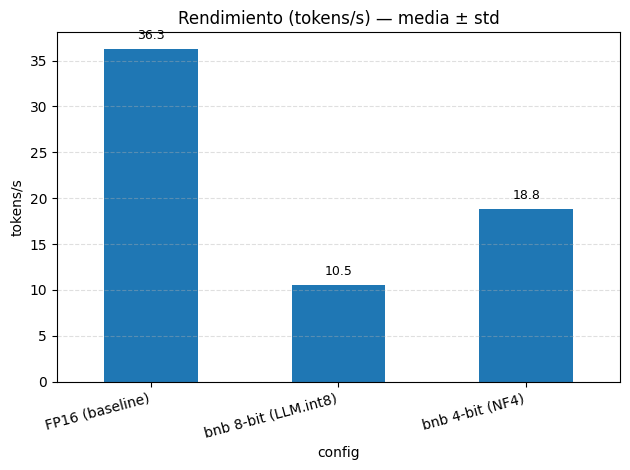

/tmp/ipython-input-2851479886.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


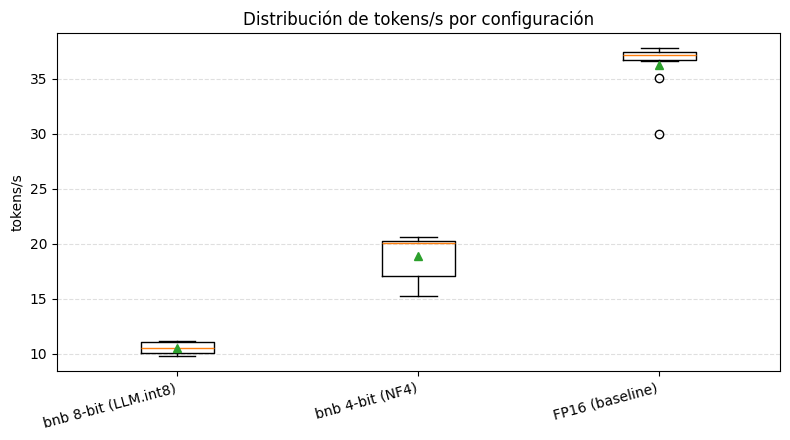

Resumen vs FP16:
- bnb 8-bit (LLM.int8): ahorro VRAM ≈ 23.6% | mejora tokens/s ≈ -71.0%
- bnb 4-bit (NF4): ahorro VRAM ≈ 34.3% | mejora tokens/s ≈ -48.1%


In [7]:
PROMPT_BM = "Explica en 2 frases qué es la cuantización affine."
MAX_NEW_TOKENS = 64
RUNS = 10
DO_FP16 = True

rows, per_run = [], {}

# 8-bit
bnb_8 = BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=6.0, llm_int8_has_fp16_weight=False)
m8 = AutoModelForCausalLM.from_pretrained(MODEL, quantization_config=bnb_8, device_map="auto")
res8 = gen_and_bench_multi(m8, tok, PROMPT_BM, MAX_NEW_TOKENS, RUNS)
rows.append({"config":"bnb 8-bit (LLM.int8)", "sec/gen": res8["sec_mean"], "tok/s": res8["tps_mean"], "tok/s_std": res8["tps_std"], "peak_VRAM_GB": res8["peak_gb"]})
per_run["bnb 8-bit (LLM.int8)"] = res8["tps_list"]
del m8; torch.cuda.empty_cache()

# 4-bit
m4 = AutoModelForCausalLM.from_pretrained(MODEL, quantization_config=bnb_4bit, device_map="auto")
res4 = gen_and_bench_multi(m4, tok, PROMPT_BM, MAX_NEW_TOKENS, RUNS)
rows.append({"config":"bnb 4-bit (NF4)", "sec/gen": res4["sec_mean"], "tok/s": res4["tps_mean"], "tok/s_std": res4["tps_std"], "peak_VRAM_GB": res4["peak_gb"]})
per_run["bnb 4-bit (NF4)"] = res4["tps_list"]
del m4; torch.cuda.empty_cache()

# FP16 baseline (opcional)
if DO_FP16:
    try:
        m0 = AutoModelForCausalLM.from_pretrained(MODEL, torch_dtype="auto", device_map="auto")
        res0 = gen_and_bench_multi(m0, tok, PROMPT_BM, MAX_NEW_TOKENS, RUNS)
        rows.insert(0, {"config":"FP16 (baseline)", "sec/gen": res0["sec_mean"], "tok/s": res0["tps_mean"], "tok/s_std": res0["tps_std"], "peak_VRAM_GB": res0["peak_gb"]})
        per_run["FP16 (baseline)"] = res0["tps_list"]
        del m0; torch.cuda.empty_cache()
    except Exception as e:
        print("⚠️ FP16 no se cargó (VRAM insuficiente). Continuamos sin baseline.")

# Tabla + CSV
df = build_benchmark_df(rows)
CSV_PATH = "/content/quantization_benchmark.csv"
df.to_csv(CSV_PATH, index=False)
print(f"CSV guardado en: {CSV_PATH}")

# Gráficos
plot_benchmark(df, per_run)

# Resumen vs FP16
print(summary_vs_fp16(df))


# ✅ Conclusiones

- **Cuantizar funciona ya**: con **8-bit (LLM.int8)** se suele lograr ~**50% menos VRAM** con mínima pérdida de calidad; **4-bit (NF4)** reduce aún más la memoria con algo más de riesgo (según tarea/modelo). La forma recomendada hoy en Transformers es pasar `BitsAndBytesConfig` en `quantization_config`.


- **QLoRA = LoRA + base 4-bit**: permite **afinar modelos grandes en una sola GPU** gracias a **NF4**, **double quantization** y **paged optimizers**, manteniendo resultados cercanos a 16-bit. :contentReference[oaicite:6]{index=6}
- **Receta portable**: el stack **Transformers + PEFT + TRL (SFTTrainer)** simplifica el SFT con adapters y es fácil de trasladar a otros modelos y datasets.


## 🧪 ¿Qué pueden experimentar?

- **Conmutar 8-bit ↔ 4-bit**: cambiar `BitsAndBytesConfig` (p.ej., `bnb_4bit_quant_type = "nf4"` vs `"fp4"`) y observar **VRAM / tokens-s**.

- **Ajustar LLM.int8**: probar distintos valores de `llm_int8_threshold` y ver el efecto en rendimiento/estabilidad.

- **Longitud del prompt**: medir latencia con prompts cortos vs largos (la **KV-cache** domina en secuencias largas).  
- **LoRA/QLoRA**: variar **r** y **lora_alpha**, y el conjunto de `target_modules` (p.ej., `["q_proj","v_proj"]` vs añadir `k_proj/o_proj`) para ver impacto en calidad y estabilidad.

- **SFT con TRL**: cambiar el tamaño del dataset y el `max_seq_length`; observar si mejora la salida en tu tarea.

> **Próximos pasos**: evaluar **AWQ/GPTQ** (weight-only) soportados por Transformers para servir checkpoints 4-bit listos, y añadir métricas de **tarea** (perplexity, EM, preferencia humana) además de la velocidad.